### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.analyses import detect_pbe_epochs
import pandas as pd
from scipy import stats
import seaborn as sns
from neuropy.plotting import Fig

import subjects


### Pooled Pbe detection

In [ ]:
sessions = subjects.nsd.mua_sess+ subjects.sd.mua_sess

In [ ]:
from scipy.ndimage import gaussian_filter1d
for sub,sess in enumerate(sessions):

    # mua =sess.neurons.get_mua()
    # mua.save(sess.filePrefix.with_suffix(".mua.npy")) 

    smth_mua = sess.mua.get_smoothed(sigma=0.02)
    pbe = detect_pbe_epochs(smth_mua,duration=(0.1,0.6))
    pbe.save(sess.filePrefix.with_suffix('.pbe'))


In [ ]:

_,ax = plt.subplots()

# ax.plot(smth_mua.time,stats.zscore(smth_mua.spike_counts))
# ax.plot(pbe.starts,0.5*np.ones_like(pbe.starts),'r*')

durations = pbe.durations
bins = np.linspace(durations.min(),durations.max(),1000)
hist_pbe_duration = np.histogram(durations,bins)[0]
hist_pbe_duration = hist_pbe_duration/np.sum(hist_pbe_duration)
ax.plot(bins[:-1],np.cumsum(hist_pbe_duration))
# ax.set_xscale('log')
# ax.set_yscale('log')

### Pbe rate change across sleep deprivation

In [6]:
sessions = subjects.nsd.mua_sess + subjects.sd.mua_sess
# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [7]:
pbe_rate_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt_start = np.array([0, 2.5, 5])
    zt_stop = np.array([2.5, 5, 7.5])
    n_epochs = len(zt_start)
    durations = (zt_stop - zt_start) * 3600

    bins = np.vstack((zt_start, zt_stop)).T.flatten() * 3600 + post[0]
    pbes = sess.pbe.starts

    binsz = np.diff(bins).mean()
    hist_pbe = np.histogram(pbes, bins=bins)[0][::2]

    pbe_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_pbe / durations,
                "Zt": [f"{zt_start[_]}-{zt_stop[_]}" for _ in range(n_epochs)],
                "sub": sub,
                "grp": sess.tag,
            }
        ),
    )

pbe_rate_df = pd.concat(pbe_rate_df, ignore_index=True)
subjects.GroupData().save(pbe_rate_df,'pbe_rate')



pbe_rate saved


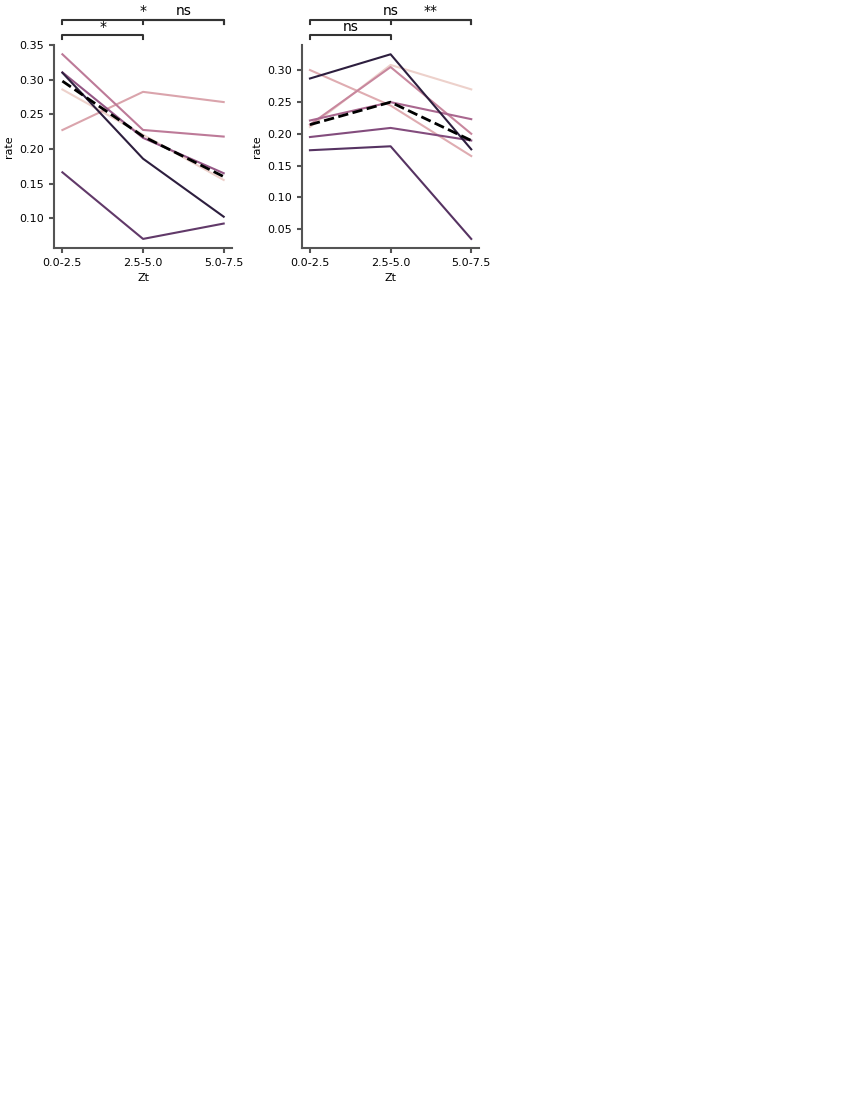

In [15]:
from statannotations.Annotator import Annotator

fig = Fig(grid=(5, 4))

for i, grp in enumerate(["NSD",'SD']):
    df = pbe_rate_df[pbe_rate_df["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        # palette="#BDBDBD",
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color='k',
        ls="--",
        ci=None,
        lw=2,
    )
    orders = df.Zt.unique()
    pairs = [(orders[t1], orders[t2]) for t1,t2 in zip([0,1,2],[1,2,0])]

    annotator = Annotator(
        ax,
        pairs,
        data=df,
        x="Zt",
        y="rate",
        order=orders,
        # hue="grp",
        # hue_order=group,
    )
    annotator.configure(
        test="t-test_paired", text_format="star", loc="outside", verbose=False
    )

    annotator.apply_and_annotate()



    # ax.set_yscale('log')
    # ax.set_ylim([0.08, 0.65])
    # ax.set_xticks(np.arange(1, 10, 2))

# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Total/mean pbe duration from first hour to last hour SD

In [ ]:
sessions = subjects.nsd.mua_sess + subjects.sd.mua_sess

In [ ]:
pbe_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.array([0,2.5,5])
    starts = zts * 3600 + post[0]
    stops = starts + 2.5*3600

    #POST is not necessarily 9 hours long
    # stops[-1] = np.min([post[1],stops[-1]])

    for i, (t1,t2) in enumerate(zip(starts, stops)):

        pbe_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i]}-{zts[i]+2.5}",
                    "pbe_duration": [sess.pbe.time_slice(t1, t2).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

pbe_duration = pd.concat(pbe_duration, ignore_index=True)
subjects.GroupData().save(pbe_duration, "pbe_total_duration")


In [ ]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))
n_subs = [7,6]
for i, grp in enumerate(["SD", "NSD"]):
    data = pbe_duration[pbe_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="pbe_duration",
        # hue="sub",
        marker="o",
        palette=["gray"] * n_subs[i],
        ax=ax,
        legend=None,
    )
    # ax.set_xlim([-1,6])
    # ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### PBE duration scatter plot/ linear regression

In [23]:
sessions = subjects.nsd.mua_sess + subjects.sd.mua_sess

In [38]:
pbe_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts = np.arange(0,5,5/60) # 5 minute bins
    starts = zts*3600 + post[0]
    stops = starts + 300

    #POST is not necessarily 9 hours long
    # stops[-1] = np.min([post[1],stops[-1]])

    for i, (t1,t2) in enumerate(zip(starts, stops)):

        pbe_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i].round(2)}",
                    "pbe_duration": [sess.pbe.time_slice(t1, t2).durations.size],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

pbe_duration = pd.concat(pbe_duration, ignore_index=True)
# subjects.GroupData().save(pbe_duration, "pbe_total_duration")


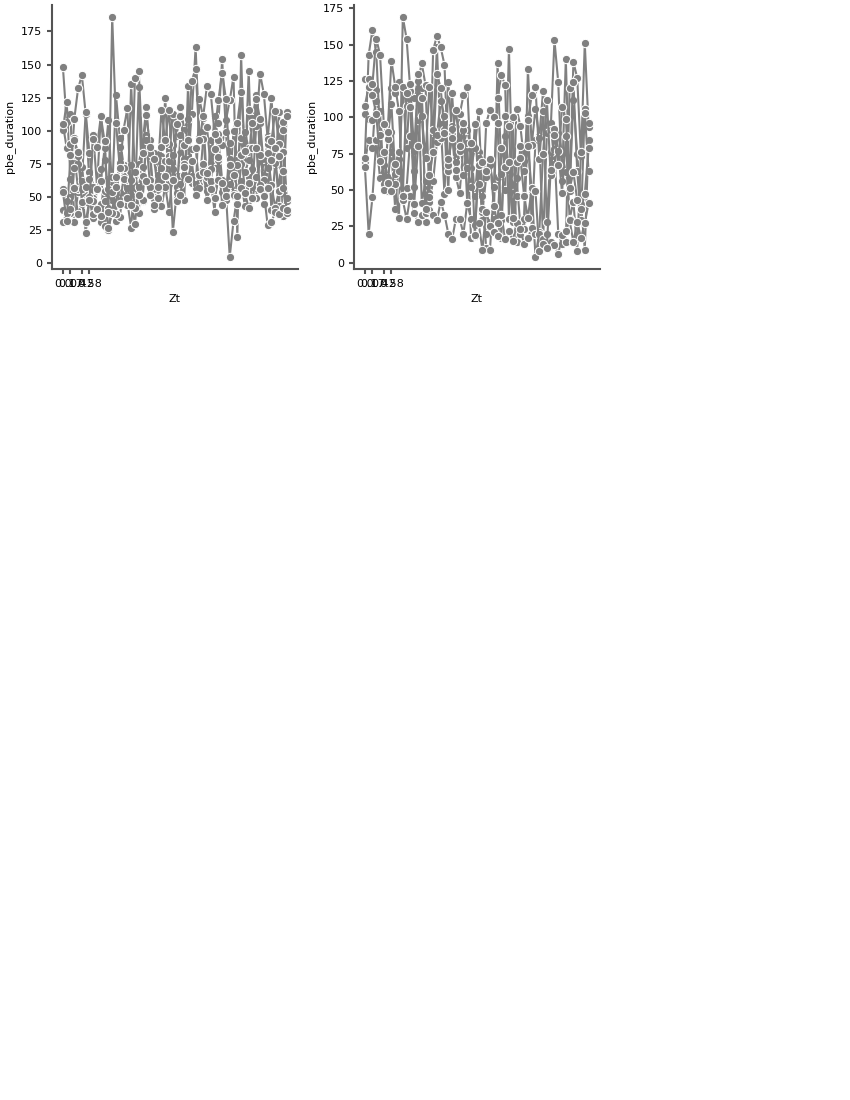

In [43]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))
n_subs = [7,6]
for i, grp in enumerate(["SD", "NSD"]):
    data = pbe_duration[pbe_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="pbe_duration",
        hue="sub",
        marker="o",
        palette=["gray"] * n_subs[i],
        ax=ax,
        legend=None,
    )
    # ax.set_xlim([-1,6])
    # ax.set_ylim([30,450])
    ax.set_xticks([0,2,5,7])
    # ax.set_yscale('log')

# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### PBE vs Ripples
- Does each pbe event comprises of only one ripple or more. How that varies across time during SD vs NSD.
- Plot similar to fig5A of Davidson et al. 2009, but using PBE duration in the x-axis instead of replay event duration.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
rpl_vs_pbe_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    epoch = [post[0]+0*3600, post[0]+1*3600]
    pbe = sess.pbe.time_slice(*epoch)
    pbe_duration = pbe.durations
    pbe_bins = pbe.flatten()
    rpl_peaktime = sess.ripple.time_slice(*epoch).to_dataframe().start.values

    rpl_per_pbe = np.histogram(rpl_peaktime, bins=pbe_bins)[0][::2]

    df = pd.DataFrame(dict(n_rpls=rpl_per_pbe, pbe_duration=pbe_duration, grp=sess.tag))
    rpl_vs_pbe_df.append(df)

rpl_vs_pbe_df = pd.concat(rpl_vs_pbe_df, ignore_index=True)
rpl_vs_pbe_df["n_rpls"] = (
    rpl_vs_pbe_df["n_rpls"] + np.random.random(len(rpl_vs_pbe_df)) * 0.1
)


In [ ]:
%matplotlib widget
import seaborn as sns

sns.scatterplot(
    data=rpl_vs_pbe_df,
    x="pbe_duration",
    y="n_rpls",
    hue="grp",
    hue_order=['NSD','SD'],
    palette=subjects.colors_sd(1.2),
    # split=True,
    # showfliers=False,
)


### Ripple band and number of peaks during PBEs
- Question: Am I over-merging during sleep deprivation compared to regular sleep.
- Here I am comparing the number of hilbert peaks (proxy for ripples) within each PBE. 
- Results: Not seeing anything interesting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,99,86]

In [ ]:
from neuropy.utils.signal_process import filter_sig, hilbertfast
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

peak_rate = []
rpl_vs_pbe_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0, 4])
    starts = zt * 3600 + post[0]

    srate = sess.eegfile.sampling_rate
    dt = 1 / srate
    smooth_window = 0.01  # 20 ms
    sigma = smooth_window / dt

    peak_rate_sub = []
    for i, s in enumerate(starts):
        pbe = sess.pbe.time_slice(s, s + 3600)

        rpl_lfp, time = sess.eegfile.get_frames_within_epochs(
            pbe, rpl_channels[sub], ret_time=True
        )
        rpl_bp = filter_sig.bandpass(rpl_lfp, fs=1250, lf=125, hf=250)
        hilbert_amp = np.abs(hilbertfast(rpl_bp))

        hilbert_smth = gaussian_filter1d(hilbert_amp, sigma=sigma)
        hilbert_smth_zsc = stats.zscore(hilbert_smth)

        peaks = find_peaks(hilbert_smth_zsc, height=1)[0]
        peak_rate_sub.append(len(peaks) / len(pbe))

        peaks_time = time[peaks]
        pbe_bins = pbe.flatten()
        rpl_per_pbe = np.histogram(peaks_time, bins=pbe_bins)[0][::2]
        df = pd.DataFrame(
            dict(n_rpls=rpl_per_pbe, pbe_duration=pbe.durations, zt=zt[i], grp=sess.tag)
        )
        rpl_vs_pbe_df.append(df)

    df = pd.DataFrame(dict(zt=zt, peak_rate=peak_rate_sub, grp=sess.tag))
    peak_rate.append(df)

peak_rate = pd.concat(peak_rate, ignore_index=True)
rpl_vs_pbe_df = pd.concat(rpl_vs_pbe_df, ignore_index=True)


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

fig = Fig(grid=(4, 3), fontsize=12, wspace=0.4, hspace=0.5)
ax = fig.subplot(fig.gs[0])
sns.boxplot(
    data=peak_rate,
    x="zt",
    y="peak_rate",
    hue="grp",
    hue_order=["NSD", "SD"],
    palette=subjects.colors_sd(1.6),
)
sns.swarmplot(
    data=peak_rate,
    x="zt",
    y="peak_rate",
    hue="grp",
    hue_order=["NSD", "SD"],
    palette=subjects.colors_sd(1),
    dodge=True,
    size=8,
    # edgecolors='w',
)
ax.set_xticks([0, 1], ["0-1", "4-5"])
ax.set_xlabel("Zt time (h)")
ax.set_ylabel("# hilbert peaks every PBE")
ax.set_title("Number of ripples\nin PBE")
ax.legend([], frameon=False)
fig.legend(ax, ["NSD", "SD"], subjects.colors_sd(1.4), x=0.8, dy=0.1, fontsize=10)


for i, grp in enumerate(["NSD", "SD"]):
    for i1, t in enumerate([0, 4]):
        ax = fig.subplot(fig.gs[i, i1 + 1])
        df = rpl_vs_pbe_df[(rpl_vs_pbe_df["grp"] == grp) & (rpl_vs_pbe_df["zt"] == t)]
        df = df[df["n_rpls"] > 0]
        x = df.pbe_duration.values
        y = df.n_rpls.values + np.random.random(len(df)) * 0.3
        linfit = stats.linregress(x, y)

        ax.scatter(
            x, y, edgecolors=subjects.colors_sd(1.2)[i], s=10, marker="o", facecolors='w'
        )
        ax.plot(x, linfit.slope * x + linfit.intercept, color="k", linewidth=2)
        if t == 0:
            ax.set_ylabel("#hilbert peaks (>1 s.d.)")
        if i == 1:
            ax.set_xlabel("PBE duration (s)")
        ax.set_title(f"Zt{t}-{t+1}, r={linfit.rvalue.round(2)}")
        ax.set_ylim([0, 8])
